<a href="https://colab.research.google.com/github/teiabessa/dio-lab-open-source/blob/main/identific_facial_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install mtcnn
!pip install opencv-python-headless
!pip install tensorflow
!pip install keras
!pip install numpy
!pip install wget

import tensorflow as tf
from tensorflow.keras.models import layers, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam
import cv2
import numpy as np
import os

from mtcnn import MTCNN
from urllib.request import urlretrieve




In [2]:
# This cell imports the drive library and mounts your Google Drive as a VM local drive. You can access to your Drive files
# using this path "/content/gdrive/My Drive/"

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
# I read pictures inside my computer google drive folder

!ls -la "/content/gdrive/Othercomputers/My Laptop/fotos_familia"


total 12
drwx------ 2 root root 4096 Feb 10 13:16 Desconhecido
drwx------ 2 root root 4096 Feb 10 13:16 Rebeca
drwx------ 2 root root 4096 Feb 10 13:17 Teia


In [8]:
dataset_path="/content/gdrive/Othercomputers/My Laptop/fotos_familia"

IMG_SIZE = (160, 160)  # Reduzido para melhor performance
BATCH_SIZE = 32        # Aumentado para acelerar treino
EPOCHS = 20
CLASSES = ['Teia', 'Rebeca', 'Desconhecido']
DATA_PATH = "/content/gdrive/Othercomputers/My Laptop/fotos_familia"

In [10]:
# ===================================================
# PREPARAR DADOS PARA TREINO
# ===================================================
#
def create_generator():
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=15,        # Reduzido
        width_shift_range=0.1,    # Reduzido
        height_shift_range=0.1,   # Reduzido
        shear_range=0.1,          # Reduzido
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2,
        fill_mode='nearest'
    )

    return train_datagen.flow_from_directory(
        DATA_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='training',
        shuffle=True
    ), train_datagen.flow_from_directory(
        DATA_PATH,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        subset='validation',
        shuffle=False
    )

train_gen, val_gen = create_generator()

Found 410 images belonging to 3 classes.
Found 102 images belonging to 3 classes.


In [12]:
# ======================================
# VERIFICAR CLASSES
# ======================================
print("\nClasses detectadas após limpeza:")
print(train_gen.class_indices)


Classes detectadas após limpeza:
{'Desconhecido': 0, 'Rebeca': 1, 'Teia': 2}


In [15]:
# ======================================
# CONSTRUIR MODELO (3 CLASSES)
# ======================================

def build_model():
    base_model = MobileNetV2(  # Modelo mais leve
        input_shape=(*IMG_SIZE, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )

    # Congelar camadas base inicialmente
    base_model.trainable = False

    model = tf.keras.Sequential([
        base_model,
        layers.Dropout(0.5),  # Adicionado para regularização
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(len(CLASSES), activation='softmax')
    ])

    model.compile(
        optimizer=Adam(0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

model = build_model()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:

# ===================================================
# TREINAR
# ===================================================
callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint('best_face_model.h5', save_best_only=True),
    ReduceLROnPlateau(factor=0.2, patience=3)
]

history = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=val_gen.samples // BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=callbacks
)

# Fine-tuning
model.layers[0].trainable = True  # Descongelar camadas base
model.compile(
    optimizer=Adam(0.0001),  # Learning rate menor
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_fine = model.fit(
    train_gen,
    steps_per_epoch=train_gen.samples // BATCH_SIZE,
    validation_data=val_gen,
    validation_steps=val_gen.samples // BATCH_SIZE,
    epochs=5,  # Poucas épocas para fine-tuning
    callbacks=callbacks
)
# Salvar o modelo final após o treinamento
#model.save('my_model.keras')

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - accuracy: 0.4955 - loss: 1.2767 

12/12 ━━━━━━━━━━━━━━━━━━━━ 219s 18s/step - accuracy: 0.5065 - loss: 1.2458 - val_accuracy: 0.7083 - val_loss: 0.6996 - learning_rate: 0.0010
Epoch 2/20
 1/12 ━━━━━━━━━━━━━━━━━━━━ 6s 584ms/step - accuracy: 0.9062 - loss: 0.2045

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


12/12 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step - accuracy: 0.9062 - loss: 0.2045 - val_accuracy: 0.7188 - val_loss: 0.6382 - learning_rate: 0.0010
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9244 - loss: 0.2060

12/12 ━━━━━━━━━━━━━━━━━━━━ 81s 7s/step - accuracy: 0.9247 - loss: 0.2056 - val_accuracy: 0.7708 - val_loss: 0.4818 - learning_rate: 0.0010
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9062 - loss: 0.1527 - val_accuracy: 0.7708 - val_loss: 0.5941 - learning_rate: 0.0010
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.9571 - loss: 0.1112 - val_accuracy: 0.8125 - val_loss: 0.6354 - learning_rate: 0.0010
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 0.9375 - loss: 0.1618 - val_accuracy: 0.7500 - val_loss: 0.6183 - learning_rate: 0.0010
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 141s 8s/step - accuracy: 0.9781 - loss: 0.0808 - val_accuracy: 0.7396 - val_loss: 0.5505 - learning_rate: 2.0000e-04
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step - accuracy: 1.0000 - loss: 0.0491 - val_accuracy: 0.7604 - val_loss: 0.6511 - learning_rate: 2.0000e-04
Epoch 1/5
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8873 - loss: 0.2791

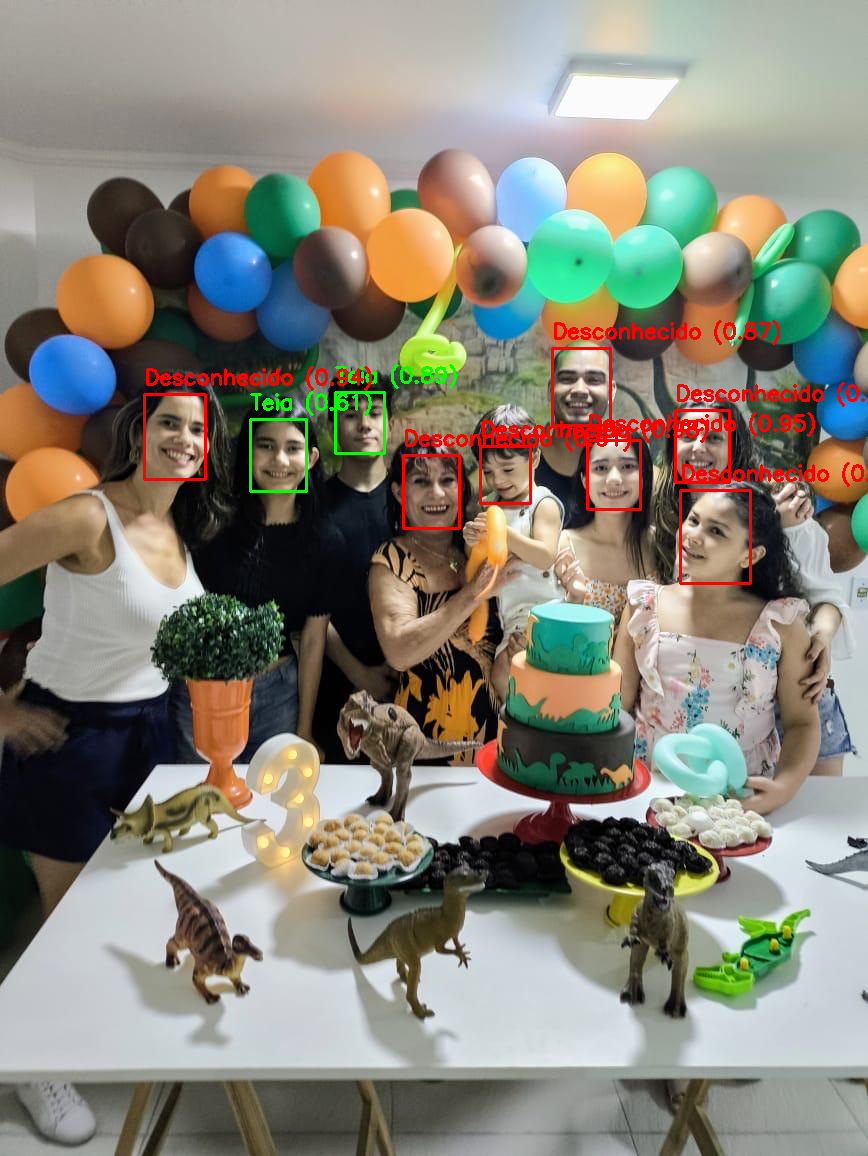

In [48]:
# ===================================================
# FUNÇÃO DE RECONHECIMENTO
# ===================================================

def detect_and_recognize(image_path, confidence_threshold=0.7):
  # Use 'min_face_size' instead of 'factor' for older versions of mtcnn
   detector = MTCNN()
   #detector = MTCNN(min_face_size=50)  # Adjust min_face_size as needed
   model = tf.keras.models.load_model('best_face_model.h5')
   img = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
   faces = detector.detect_faces(img)

   for face in faces:
      if face['confidence'] < 0.85:
          continue

      x, y, w, h = face['box']
      x, y = abs(x), abs(y)

      # Extract ROI with margin
      margin = int(0.25 * max(w, h))
      face_roi = img[
      max(0, y-margin):min(img.shape[0], y+h+margin),
      max(0, x-margin):min(img.shape[1], x+w+margin)
      ]

      # Preprocessing
      face_roi = cv2.resize(face_roi, IMG_SIZE)
      face_roi = face_roi.astype('float32') / 255.0
      face_roi = np.expand_dims(face_roi, axis=0)

      # Prediction
      preds = model.predict(face_roi, verbose=0)[0]
      class_idx = np.argmax(preds)
      confidence = preds[class_idx]

      label = CLASSES[class_idx] if confidence > confidence_threshold else 'Desconhecido'

      # Draw annotations
      color = (0, 255, 0) if label != 'Desconhecido' else (255, 0, 0)
      cv2.rectangle(img, (x, y), (x+w, y+h), color, 2)
      cv2.putText(img, f"{label} ({confidence:.2f})",
                (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color, 2)

   # Convert back to BGR for proper color display
   img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

   # Use Colab-compatible display
   cv2_imshow(img)  # Changed from cv2.imshow()

# Test
detect_and_recognize("rosto_familia.jpg", confidence_threshold=0.6)